<a href="https://colab.research.google.com/github/ethanp55/Forex-AI/blob/master/forex_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install talib for technical indicators
# %%capture will suppress all output - these commands produce way too many
#   output statments
%%capture
! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
! tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
! ./configure --prefix=/usr
! make
! make install
! pip install Ta-Lib

### Imports and file path

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import webbrowser
import math
import talib

file_path = '/content/drive/My Drive/Forex_AI/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Mount google drive for accessing files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Read in and clean/prepare data

In [101]:
df = pd.read_csv(file_path + 'EURUSD_Candlestick_1_Hour_ASK_03.05.2003-16.04.2020.csv')
df.rename(columns={'Gmt time': 'Date'}, inplace=True)
df.Date = pd.to_datetime(df.Date, format='%d.%m.%Y %H:%M:%S.%f')
df.drop_duplicates(subset=df.columns.difference(['Date']), keep=False, inplace=True)

df

,Date,Open,High,Low,Close,Volume
21,2003-05-04 21:00:00,1.12354,1.12354,1.12279,1.12331,24206.5996
22,2003-05-04 22:00:00,1.12290,1.12317,1.12240,1.12251,23023.5996
23,2003-05-04 23:00:00,1.12255,1.12255,1.12176,1.12179,24839.6992
24,2003-05-05 00:00:00,1.12177,1.12318,1.12166,1.12274,23463.1992
25,2003-05-05 01:00:00,1.12242,1.12276,1.12119,1.12150,25406.5996
...,...,...,...,...,...,...
148648,2020-04-17 16:00:00,1.08833,1.08843,1.08595,1.08671,10567.5300
148649,2020-04-17 17:00:00,1.08673,1.08851,1.08672,1.08763,9090.0200
148650,2020-04-17 18:00:00,1.08763,1.08775,1.08663,1.08686,7907.0100
148651,2020-04-17 19:00:00,1.08687,1.08741,1.08644,1.08691,5097.3500


In [0]:
# # Plot the data
# trace = go.Figure(go.Ohlc(x=df.Date, open=df.Open, high=df.High,
#                                low=df.Low, close=df.Close, name='Currency Quote'))
# trace.show(renderer="colab")

,Open,High,Low,Close,Volume,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
21,1.12354,1.12354,1.12279,1.12331,24206.5996,-0.707107,0.707107,-0.433884,-0.900969,0.5,-0.866025
22,1.12290,1.12317,1.12240,1.12251,23023.5996,-0.500000,0.866025,-0.433884,-0.900969,0.5,-0.866025
23,1.12255,1.12255,1.12176,1.12179,24839.6992,-0.258819,0.965926,-0.433884,-0.900969,0.5,-0.866025
24,1.12177,1.12318,1.12166,1.12274,23463.1992,0.000000,1.000000,-0.974928,-0.222521,0.5,-0.866025
25,1.12242,1.12276,1.12119,1.12150,25406.5996,0.258819,0.965926,-0.974928,-0.222521,0.5,-0.866025


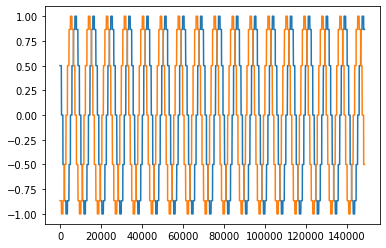

In [103]:
# Add hour of day, day of week, and month of year (for additional features)
# Use sine and cosine to keep the cyclic nature of hour, day, and month
#  (December is closer to January than October, midnight is closer to 1 am than
#  10 pm, etc.)
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
df['sin_day'] = np.sin(2 * np.pi * df['Date'].dt.day / 7)
df['cos_day'] = np.cos(2 * np.pi * df['Date'].dt.day / 7)
df['sin_month'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

# Drop the original date column (it is no longer needed)
df.drop('Date', axis=1, inplace=True)

# Plots to illustrate cyclic nature of time
df.sin_month.plot()
df.cos_month.plot()

# Show the updated dataframe
df.head()

In [104]:
# Add technical indicators (for additional features)
df['SMA1'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA1_Envelope_Upper'] = df['SMA1'] + (0.1 * df['SMA1'])
df['SMA1_Envelope_Lower'] = df['SMA1'] - (0.1 * df['SMA1'])
df['EMA1'] = talib.EMA(df['Close'], timeperiod=10)
df['EMA1_Envelope_Upper'] = df['EMA1'] + (0.1 * df['EMA1'])
df['EMA1_Envelope_Lower'] = df['EMA1'] - (0.1 * df['EMA1'])
df['SMA2'] = talib.SMA(df['Close'], timeperiod=20)
df['SMA2_Envelope_Upper'] = df['SMA2'] + (0.1 * df['SMA2'])
df['SMA2_Envelope_Lower'] = df['SMA2'] - (0.1 * df['SMA2'])
df['EMA2'] = talib.EMA(df['Close'], timeperiod=20)
df['EMA2_Envelope_Upper'] = df['EMA2'] + (0.1 * df['EMA2'])
df['EMA2_Envelope_Lower'] = df['EMA2'] - (0.1 * df['EMA2'])
df['SMA3'] = talib.SMA(df['Close'], timeperiod=30)
df['SMA3_Envelope_Upper'] = df['SMA3'] + (0.1 * df['SMA3'])
df['SMA3_Envelope_Lower'] = df['SMA3'] - (0.1 * df['SMA3'])
df['EMA3'] = talib.EMA(df['Close'], timeperiod=30)
df['EMA3_Envelope_Upper'] = df['EMA3'] + (0.1 * df['EMA3'])
df['EMA3_Envelope_Lower'] = df['EMA3'] - (0.1 * df['EMA3'])
df['BB_Upper_Band'], df['BB_Middle_Band'], df['BB_Lower_Band'] = talib.BBANDS(
    df['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['MACD'], df['MACD_Signal'], df['MACD_hist'] = talib.MACD(df['Close'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Parabollic_SAR'] = talib.SAR(df['High'], df['Low'], acceleration=0, maximum=0)
df['Slowk'], df['Slowd'] = talib.STOCH(df['High'], df['Low'], df['Close'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Williams_Percent_Range'] = talib.WILLR(df['High'], df['Low'], df['Close'],
                                           timeperiod=14)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['ADXR'] = talib.ADXR(df['High'], df['Low'], df['Close'], timeperiod=14)
df['MOM'] = talib.MOM(df['Close'], timeperiod=10)
df['BOP'] = talib.BOP(df['Open'], df['High'], df['Low'], df['Close'])
df['AROONOSC'] = talib.AROONOSC(df['High'], df['Low'], timeperiod=14)
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

df

,Open,High,Low,Close,Volume,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,SMA1,SMA1_Envelope_Upper,SMA1_Envelope_Lower,EMA1,EMA1_Envelope_Upper,EMA1_Envelope_Lower,SMA2,SMA2_Envelope_Upper,SMA2_Envelope_Lower,EMA2,EMA2_Envelope_Upper,EMA2_Envelope_Lower,SMA3,SMA3_Envelope_Upper,SMA3_Envelope_Lower,EMA3,EMA3_Envelope_Upper,EMA3_Envelope_Lower,BB_Upper_Band,BB_Middle_Band,BB_Lower_Band,MACD,MACD_Signal,MACD_hist,Parabollic_SAR,Slowk,Slowd,RSI,Williams_Percent_Range,ADX,ADXR,MOM,BOP,AROONOSC,ATR
21,1.12354,1.12354,1.12279,1.12331,24206.5996,-0.707107,7.071068e-01,-0.433884,-0.900969,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.306667,NaN,NaN
22,1.12290,1.12317,1.12240,1.12251,23023.5996,-0.500000,8.660254e-01,-0.433884,-0.900969,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.506494,NaN,NaN
23,1.12255,1.12255,1.12176,1.12179,24839.6992,-0.258819,9.659258e-01,-0.433884,-0.900969,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.962025,NaN,NaN
24,1.12177,1.12318,1.12166,1.12274,23463.1992,0.000000,1.000000e+00,-0.974928,-0.222521,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.638158,NaN,NaN
25,1.12242,1.12276,1.12119,1.12150,25406.5996,0.258819,9.659258e-01,-0.974928,-0.222521,0.500000,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.123676,1.122370,1.121064,NaN,NaN,NaN,1.12354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.585987,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148648,1.08833,1.08843,1.08595,1.08671,10567.5300,-0.866025,-5.000000e-01,0.433884,-0.900969,0.866025,-0.500000,1.085541,1.194095,0.976987,1.086589,1.195248,0.977930,1.086021,1.194623,0.977419,1.086287,1.194916,0.977658,1.085848,1.194432,0.977263,1.086569,1.195226,0.977912,1.089890,1.087822,1.085754,0.000030,-0.000472,0.000502,1.60403,75.616634,86.858611,50.967725,-32.009926,23.493990,25.609067,0.00128,-0.653226,28.571429,0.002016
148649,1.08673,1.08851,1.08672,1.08763,9090.0200,-0.965926,-2.588190e-01,0.433884,-0.900969,0.866025,-0.500000,1.086016,1.194618,0.977414,1.086778,1.195456,0.978101,1.086089,1.194698,0.977481,1.086415,1.195056,0.977773,1.085828,1.194411,0.977245,1.086637,1.195301,0.977974,1.089669,1.088056,1.086443,0.000122,-0.000353,0.000475,1.60403,60.331819,76.059035,54.133279,-20.595533,21.981728,24.345460,0.00475,0.502793,28.571429,0.002001
148650,1.08763,1.08775,1.08663,1.08686,7907.0100,-1.000000,-1.836970e-16,0.433884,-0.900969,0.866025,-0.500000,1.086406,1.195047,0.977765,1.086793,1.195473,0.978114,1.086127,1.194740,0.977515,1.086457,1.195103,0.977812,1.085758,1.194334,0.977182,1.086652,1.195317,0.977987,1.089428,1.087702,1.085976,0.000131,-0.000257,0.000388,1.60403,41.522499,59.156984,51.156438,-30.148883,20.516651,23.145241,0.00390,-0.687500,28.571429,0.001938
148651,1.08687,1.08741,1.08644,1.08691,5097.3500,-0.965926,2.588190e-01,0.433884,-0.900969,0.866025,-0.500000,1.086899,1.195589,0.978209,1.086814,1.195496,0.978133,1.086178,1.194796,0.977560,1.086500,1.195151,0.977850,1.085725,1.194297,0.977152,1.086668,1.195335,0.978002,1.088509,1.087288,1.086067,0.000141,-0.000177,0.000318,1.60403,36.170884,46.008401,51.343548,-29.528536,19.080735,22.567383,0.00493,0.041237,28.571429,0.001869


In [105]:
subset = df.iloc[0:50, :]

# Scale each column to be between -1 and 1
for j in range(subset.shape[1]):
  if not (subset.iloc[:, j].max() <= 1 and subset.iloc[:, j].min() >= -1):
    subset.iloc[:, j] = ((subset.iloc[:, j] - subset.iloc[:, j].max()) + (subset.iloc[:, j] - subset.iloc[:, j].min())) / (subset.iloc[:, j].max() - subset.iloc[:, j].min())

# Find RP matrix before converting values to arc cosine values
# See the paper found at https://arxiv.org/pdf/1710.00886.pdf
RP = []

for i in range(subset.shape[0]):
  RP_curr_row = []

  for j in range(subset.shape[0]):
    RP_curr_row.append(np.linalg.norm(subset.iloc[i, :] - subset.iloc[j, :]))

  RP.append(RP_curr_row)

RP = np.expand_dims(RP, axis=0)

# Change data to arc cosine values (in order to find GASF and GADF)
for j in range(subset.shape[1]):
  for i in range(subset.shape[0]):
    subset.iloc[i, j] = math.acos(subset.iloc[i, j])

subset.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Volume,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,SMA1,SMA1_Envelope_Upper,SMA1_Envelope_Lower,EMA1,EMA1_Envelope_Upper,EMA1_Envelope_Lower,SMA2,SMA2_Envelope_Upper,SMA2_Envelope_Lower,EMA2,EMA2_Envelope_Upper,EMA2_Envelope_Lower,SMA3,SMA3_Envelope_Upper,SMA3_Envelope_Lower,EMA3,EMA3_Envelope_Upper,EMA3_Envelope_Lower,BB_Upper_Band,BB_Middle_Band,BB_Lower_Band,MACD,MACD_Signal,MACD_hist,Parabollic_SAR,Slowk,Slowd,RSI,Williams_Percent_Range,ADX,ADXR,MOM,BOP,AROONOSC,ATR
21,2.449121,2.574605,2.453890,2.501298,2.891138,2.356194,0.785398,2.019595,2.692794,1.047198,2.617994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.882485,NaN,NaN
22,2.542653,2.636563,2.512067,2.629514,2.938331,2.094395,0.523599,2.019595,2.692794,1.047198,2.617994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.101910,NaN,NaN
23,2.599640,2.760273,2.619400,2.777803,2.869162,1.832596,0.261799,2.019595,2.692794,1.047198,2.617994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.865124,NaN,NaN
24,2.752556,2.634799,2.638003,2.589937,2.919640,1.570796,0.000000,2.917193,1.795196,1.047198,2.617994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878693,NaN,NaN
25,2.622222,2.714607,2.735721,2.857300,2.850858,1.308997,0.261799,2.917193,1.795196,1.047198,2.617994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580612,2.675575,2.519255,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.196894,NaN,NaN


In [106]:
# Convert time series data to rich image data
# See the following papers:
#   https://arxiv.org/pdf/1908.08036.pdf pages 4 and 5 for Gram matrices in general
#   https://arxiv.org/pdf/1506.00327.pdf page 2 for GASF and GADF in specific
GASF = []
GADF = []

for j in range(subset.shape[1]):
  GASF_curr_matrix = []
  GADF_curr_matrix = []

  for i in range(subset.shape[0]):
    GASF_curr_row = []
    GADF_curr_row = []

    for k in range(subset.shape[0]):
      GASF_curr_row.append(math.cos(subset.iloc[i, j] + subset.iloc[k, j]))
      GADF_curr_row.append(math.sin(subset.iloc[i, j] - subset.iloc[k, j]))

    GASF_curr_matrix.append(GASF_curr_row)
    GADF_curr_matrix.append(GADF_curr_row)

  GASF.append(GASF_curr_matrix)
  GADF.append(GADF_curr_matrix)

GASF = np.array(GASF)
GADF = np.array(GADF)

print('GASF shape: ' + str(GASF.shape))
print('GADF shape: ' + str(GADF.shape))
print('RP shape: ' + str(RP.shape))

image_data = np.append(GASF, GADF, axis=0)
image_data = np.append(image_data, RP, axis=0)
print('Final image data shape: ' + str(image_data.shape))

GASF shape: (46, 50, 50)
GADF shape: (46, 50, 50)
RP shape: (1, 50, 50)
Final image data shape: (93, 50, 50)


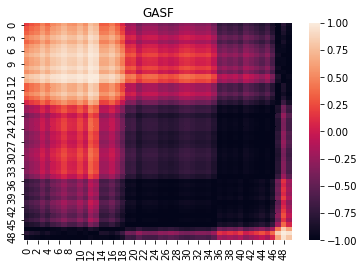

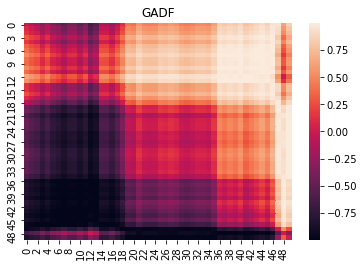

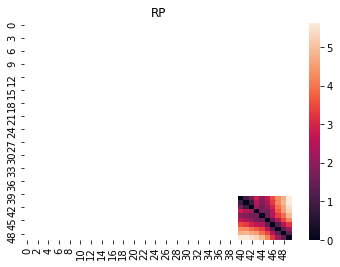

In [108]:
# Plot sample heat maps
ax = sns.heatmap(GASF[0])
ax.set_title('GASF')
plt.show()
ax = sns.heatmap(GADF[0])
ax.set_title('GADF')
plt.show()
ax = sns.heatmap(RP[0])
ax.set_title('RP')
plt.show()